In [170]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

from datetime import datetime




In [171]:
#Define paths
currentDir = os.getcwd()
accelerometerDataPath = os.path.join(currentDir, "data", "all_accelerometer_data_pids_13.csv")
tacDataPath = os.path.join(currentDir, "data", "clean_tac")
phoneTypesPath = os.path.join(currentDir, "data", "phone_types.csv")

In [172]:
#Combine clean_tac into one dataframe
csvFiles = glob.glob(os.path.join(tacDataPath, '*.csv'))
print(csvFiles)
tacDataFrames = []

for csvFile in csvFiles:
    tacDataFrames.append(pd.read_csv(csvFile))

['c:\\Users\\heath\\OneDrive\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\BK7610_clean_TAC.csv', 'c:\\Users\\heath\\OneDrive\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\BU4707_clean_TAC.csv', 'c:\\Users\\heath\\OneDrive\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\CC6740_clean_TAC.csv', 'c:\\Users\\heath\\OneDrive\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\DC6359_clean_TAC.csv', 'c:\\Users\\heath\\OneDrive\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\DK3500_clean_TAC.csv', 'c:\\Users\\heath\\OneDrive\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\HV0618_clean_TAC.csv', 'c:\\Users\\heath\\OneDrive\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\JB3156_clean_TAC.csv', 'c:\\Users\\heath\\OneDrive\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\JR8022_clean_TAC.csv', 'c:\\Users\\heath\\OneDrive\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\MC7070_clean_TAC.csv', 'c:\\Users\\heath\\OneDrive

In [173]:
#Loading data files

tacData = pd.concat(tacDataFrames, ignore_index=True)
accelerometerData = pd.read_csv(accelerometerDataPath)
phoneTypes = pd.read_csv(phoneTypesPath)

In [174]:
#Check dataframes
tacData.head()
accelerometerData.head()
phoneTypes.head()


,pid,phonetype
0,BK7610,iPhone
1,BU4707,iPhone
2,CC6740,Android
3,DC6359,iPhone
4,DK3500,iPhone


In [175]:
#Check for null
tacData.isnull().sum()
accelerometerData.isnull().sum()
phoneTypes.isnull().sum()

pid          0
phonetype    0
dtype: int64

In [176]:
print(tacData)

      timestamp  TAC_Reading
0    1493718714    -0.000482
1    1493720697     0.001573
2    1493721027     0.002144
3    1493721357     0.000877
4    1493721686    -0.001145
..          ...          ...
710  1493797974     0.029049
711  1493799820     0.016286
712  1493801652     0.004243
713  1493803481    -0.001995
714  1493805310    -0.002919

[715 rows x 2 columns]


In [177]:
#Connect accelerometer data with their respective phone types
accelerometerData = accelerometerData.merge(phoneTypes, on='pid')
print(accelerometerData)

                   time     pid         x         y         z phonetype
0                     0  JB3156  0.000000  0.000000  0.000000   Android
1                     0  CC6740  0.000000  0.000000  0.000000   Android
2         1493733882409  SA0297  0.075800  0.027300 -0.010200    iPhone
3         1493733882455  SA0297 -0.035900  0.079400  0.003700    iPhone
4         1493733882500  SA0297 -0.242700 -0.086100 -0.016300    iPhone
...                 ...     ...       ...       ...       ...       ...
14057562  1493829248196  CC6740 -0.133956  0.124726 -0.010736   Android
14057563  1493829248220  CC6740 -0.100764  0.180872  0.046449   Android
14057564  1493829248245  CC6740 -0.131853  0.195934  0.181088   Android
14057565  1493829248270  CC6740 -0.149704  0.194482  0.202393   Android
14057566  1493829248294  CC6740 -0.107288  0.153548  0.168595   Android

[14057567 rows x 6 columns]


In [178]:
#Identify bar crawl events (increased movement)
segmentLength = 60
barCrawlEvents = []

tacData['timestamp'] *= 1000
print(tacData)

print(accelerometerData)

         timestamp  TAC_Reading
0    1493718714000    -0.000482
1    1493720697000     0.001573
2    1493721027000     0.002144
3    1493721357000     0.000877
4    1493721686000    -0.001145
..             ...          ...
710  1493797974000     0.029049
711  1493799820000     0.016286
712  1493801652000     0.004243
713  1493803481000    -0.001995
714  1493805310000    -0.002919

[715 rows x 2 columns]
                   time     pid         x         y         z phonetype
0                     0  JB3156  0.000000  0.000000  0.000000   Android
1                     0  CC6740  0.000000  0.000000  0.000000   Android
2         1493733882409  SA0297  0.075800  0.027300 -0.010200    iPhone
3         1493733882455  SA0297 -0.035900  0.079400  0.003700    iPhone
4         1493733882500  SA0297 -0.242700 -0.086100 -0.016300    iPhone
...                 ...     ...       ...       ...       ...       ...
14057562  1493829248196  CC6740 -0.133956  0.124726 -0.010736   Android
14057563  149382

In [189]:
#Iterate through participants data
for participant_id, participant_data in accelerometerData.groupby('pid'):
    participant_data['magnitude'] = np.sqrt(participant_data['x']**2 + participant_data['y']**2 + participant_data['z']**2)

# Define threshold
threshold = 0.01  # Adjust threshold value as needed

# Identify segments
segments = []
segment_start = None
current_id = None

for index, row in participant_data.iterrows():
    if row['magnitude'] > threshold:
        if segment_start is None:
            segment_start = row['time']
            current_id = row['pid']
    else:
        if segment_start is not None:
            segment_end = row['time']
            segments.append((current_id, segment_start, segment_end))
            segment_start = None
            current_id = None

# Create DataFrame for segments
barCrawlEventsDf = pd.DataFrame(segments, columns=['id', 'segment_start', 'segment_end'])

print(barCrawlEventsDf)

           id  segment_start    segment_end
0      SF3079  1493739196712  1493739196787
1      SF3079  1493739196811  1493739197335
2      SF3079  1493739197373  1493739197553
3      SF3079  1493739197557  1493739198288
4      SF3079  1493739198309  1493739198348
...       ...            ...            ...
23120  SF3079  1493790822313  1493790822348
23121  SF3079  1493790822428  1493790822463
23122  SF3079  1493790822499  1493790822821
23123  SF3079  1493790822880  1493790823547
23124  SF3079  1493790823572  1493790823603

[23125 rows x 3 columns]


In [195]:
# Define heavy drinking episodes based on the TAC threshold (United States legislation threshold 0.08)
tacThreshold = 0.08
tolerance_ms = 60 * 10**9
heavyDrinkingEpisodes = tacData[tacData['TAC_Reading'] >= tacThreshold]
lightDrinkingEpisodes = tacData[tacData['TAC_Reading'] < tacThreshold]
heavyDrinkingEpsidoesDf = pd.DataFrame(heavyDrinkingEpisodes)
lightDrinkingEpisodesDf = pd.DataFrame(lightDrinkingEpisodes)

# Merge barCrawlEventsDf with heavyDrinkingEpisodes based on timestamps
aboveMergeData = pd.merge_asof(barCrawlEventsDf.sort_values('segment_start'), 
                          heavyDrinkingEpsidoesDf.sort_values('timestamp'), 
                          left_on='segment_start', 
                          right_on='timestamp', 
                          direction='nearest',
                          tolerance=tolerance_ms)  # Adjust tolerance as needed

belowMergeData = pd.merge_asof(barCrawlEventsDf.sort_values('segment_start'), 
                          lightDrinkingEpisodesDf.sort_values('timestamp'), 
                          left_on='segment_start', 
                          right_on='timestamp', 
                          direction='nearest',
                          tolerance=tolerance_ms)  # Adjust tolerance as needed

# Filter mergeData to include only rows where the TAC reading timestamp is within the segment_start and segment_end of barCrawlEventDf
#filtered_mergeData = mergeData[(mergeData['timestamp'] >= mergeData['segment_start']) & 
#                               (mergeData['timestamp'] <= mergeData['segment_end'])]

# Print filtered_mergeData
#print(filtered_mergeData)


# Calculate correlation between filtered timestamps and TAC readings
correlation = aboveMergeData['TAC_Reading'].corr(belowMergeData['TAC_Reading'])
print("Correlation between bar crawl events above .08 and bar crawl events below .08: ", correlation)

           id  segment_start    segment_end      timestamp  TAC_Reading
303    SF3079  1493739246689  1493739273686  1493739266000     0.205234
867    SF3079  1493739731612  1493740082349  1493739745000     0.088046
1691   SF3079  1493740821609  1493740846919  1493740845000     0.085197
4095   SF3079  1493741972388  1493742218540  1493742096000     0.082124
4896   SF3079  1493742860805  1493742873129  1493742871000     0.090165
5032   SF3079  1493742956561  1493742966992  1493742961000     0.130305
5656   SF3079  1493743425508  1493743427087  1493743427000     0.086116
5944   SF3079  1493743603207  1493743609406  1493743607000     0.111503
6310   SF3079  1493744003355  1493744046235  1493744018000     0.087869
6593   SF3079  1493744393975  1493744396161  1493744395000     0.085436
8132   SF3079  1493744806953  1493744827575  1493744810000     0.101965
8155   SF3079  1493744842400  1493744843029  1493744843000     0.089122
8580   SF3079  1493745268635  1493745273593  1493745269000     0

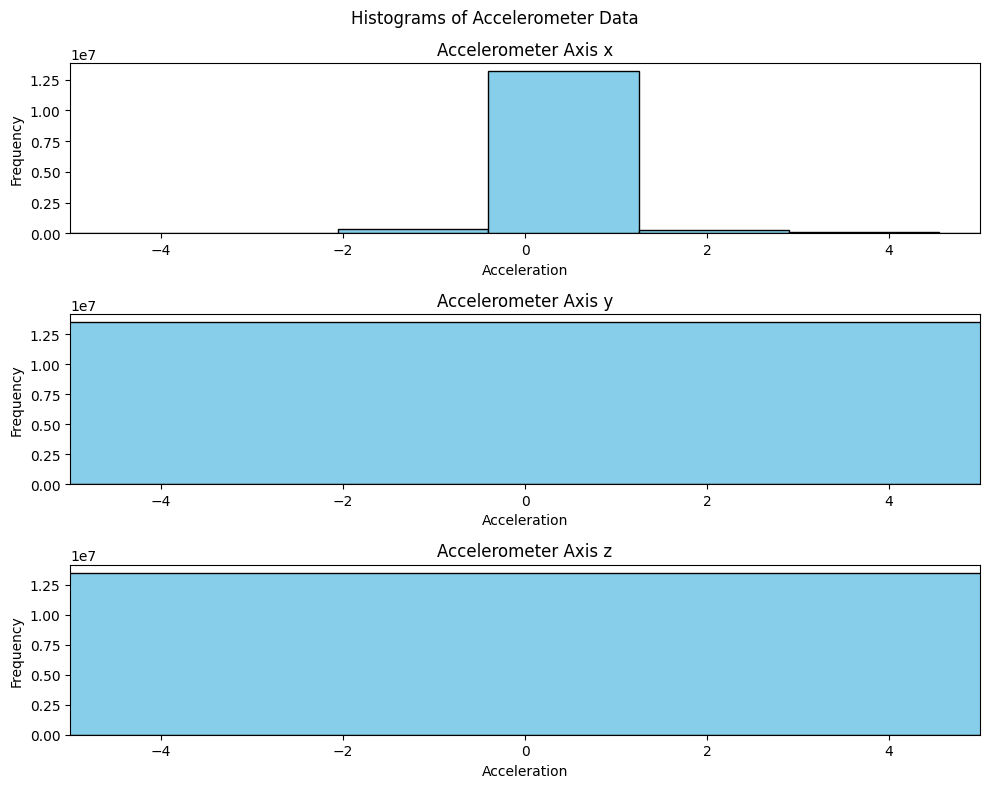

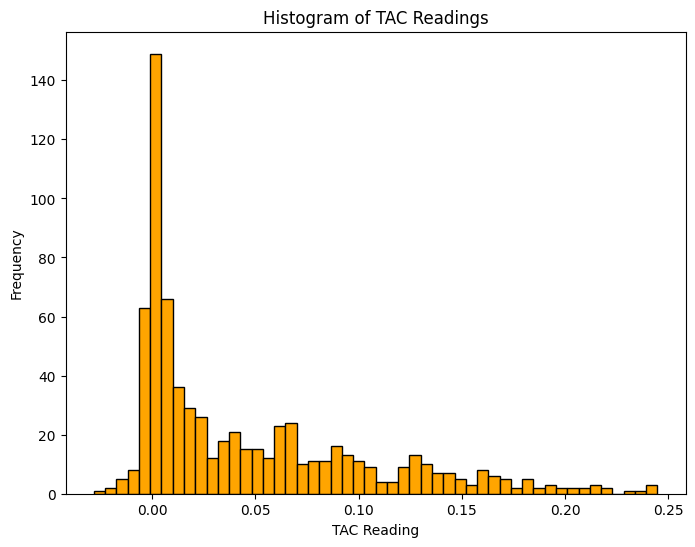

In [192]:
#Set up the figure
fig, axs = plt.subplots(3, 1, figsize=(10, 8))
fig.suptitle('Histograms of Accelerometer Data')

#Plot histograms
for i, axis in enumerate(['x', 'y', 'z']):
    axs[i].hist(accelerometerData[axis], bins=50, color='skyblue', edgecolor='black')
    axs[i].set_title(f'Accelerometer Axis {axis}')
    axs[i].set_xlabel('Acceleration')
    axs[i].set_ylabel('Frequency')
    axs[i].set_xlim(-5, 5)

plt.tight_layout()
plt.show()

#TAC histogram
plt.figure(figsize=(8, 6))
plt.hist(tacData['TAC_Reading'], bins=50, color='orange', edgecolor='black')
plt.title('Histogram of TAC Readings')
plt.xlabel('TAC Reading')
plt.ylabel('Frequency')
plt.show()

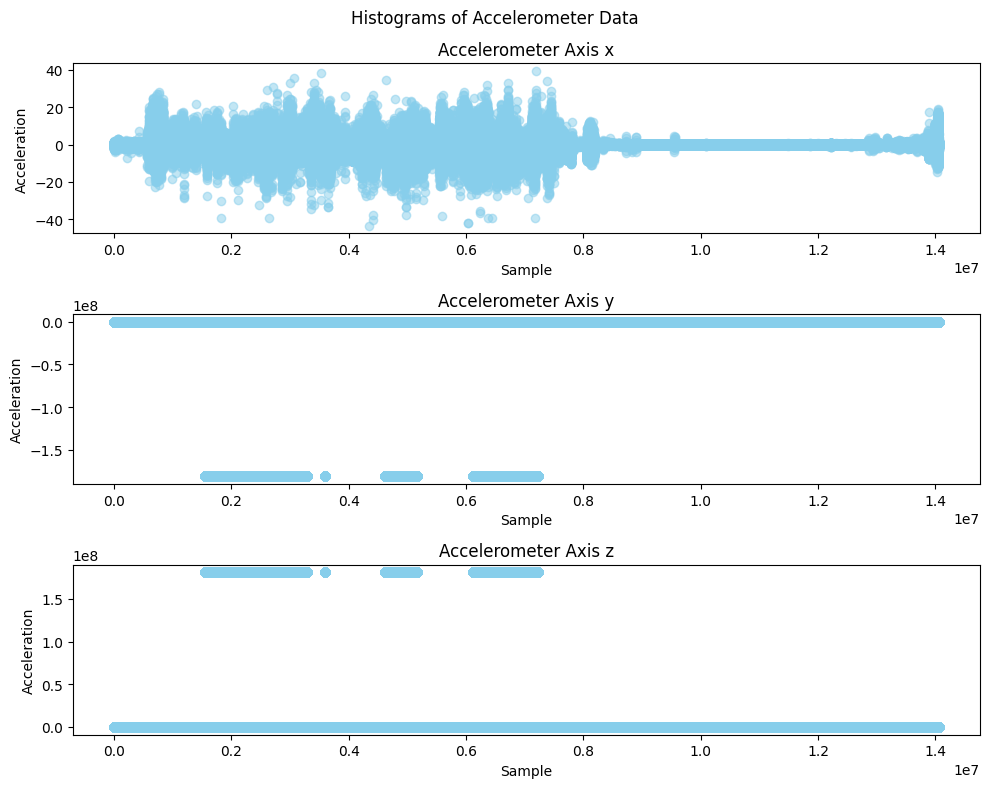

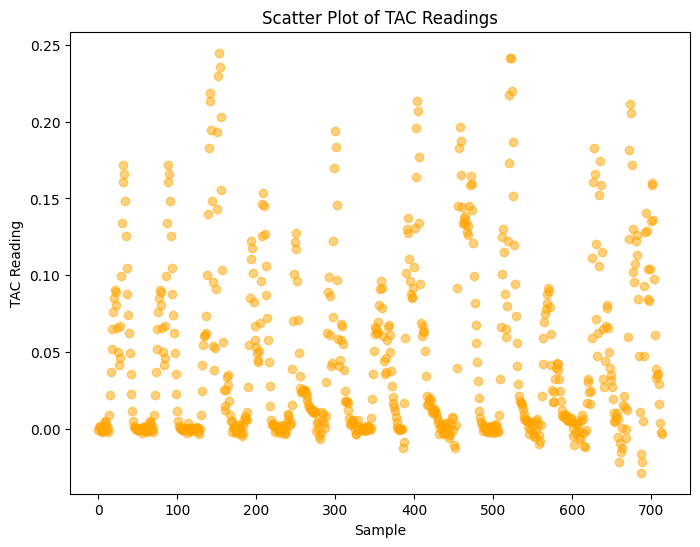

In [193]:
#Set up the figure
fig, axs = plt.subplots(3, 1, figsize=(10, 8))
fig.suptitle('Histograms of Accelerometer Data')

# Plot scatter plots for accelerometer data
for i, axis in enumerate(['x', 'y', 'z']):
    axs[i].scatter(range(len(accelerometerData[axis])), accelerometerData[axis], color='skyblue', alpha=0.5)
    axs[i].set_title(f'Accelerometer Axis {axis}')
    axs[i].set_xlabel('Sample')
    axs[i].set_ylabel('Acceleration')

plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(range(len(tacData['TAC_Reading'])), tacData['TAC_Reading'], color='orange', alpha=0.5)
plt.title('Scatter Plot of TAC Readings')
plt.xlabel('Sample')
plt.ylabel('TAC Reading')
plt.show()

In [183]:
# Remove NaN values and negative values from the TAC readings column
clean_tac_data = mergeData['TAC_Reading'].dropna().clip(lower=0)
# Check the value of tacThreshold
print("TAC Threshold:", tacThreshold)

# Ensure mergeData contains 'TAC_Reading' column
print("Columns in mergeData:", mergeData.columns)

# Debug the condition used to assign values to 'heavy_drinking_episode' column
print("Condition for heavy drinking episode assignment:")
false_count = 0
for index, tac_reading in enumerate(clean_tac_data):
    condition_result = tac_reading >= tacThreshold
    print(f"TAC Reading at index {index}: {tac_reading}, Condition Result: {condition_result}")
    if not condition_result:
        false_count += 1

print("Number of 'False' results:", false_count)

TAC Threshold: 0.08
Columns in mergeData: Index(['id', 'segment_start', 'segment_end', 'timestamp', 'TAC_Reading'], dtype='object')
Condition for heavy drinking episode assignment:
TAC Reading at index 0: 0.205234334214655, Condition Result: True
TAC Reading at index 1: 0.205234334214655, Condition Result: True
TAC Reading at index 2: 0.205234334214655, Condition Result: True
TAC Reading at index 3: 0.205234334214655, Condition Result: True
TAC Reading at index 4: 0.205234334214655, Condition Result: True
TAC Reading at index 5: 0.205234334214655, Condition Result: True
TAC Reading at index 6: 0.205234334214655, Condition Result: True
TAC Reading at index 7: 0.205234334214655, Condition Result: True
TAC Reading at index 8: 0.205234334214655, Condition Result: True
TAC Reading at index 9: 0.205234334214655, Condition Result: True
TAC Reading at index 10: 0.205234334214655, Condition Result: True
TAC Reading at index 11: 0.205234334214655, Condition Result: True
TAC Reading at index 12: 

In [194]:
contained = heavyDrinkingEpisodes['timestamp'].isin(mergeData['timestamp']).all()

if contained:
    print("All heavy drinking episodes are contained within mergeData['heavy_drinking_episodes'].")
else:
    print("Some heavy drinking episodes are not contained within mergeData['heavy_drinking_episodes'].")

Some heavy drinking episodes are not contained within mergeData['heavy_drinking_episodes'].


In [185]:
#EDA

X = mergeData['TAC_Reading']
y = mergeData['heavy_drinking_episode']

print(mergeData['heavy_drinking_episode'])

print(X)
print(y)

KeyError: 'heavy_drinking_episode'

In [186]:
#Handle any NA 
X = X.fillna(X.mean())

In [187]:
#Train-test split
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

X_train = X_train.values.reshape(-1, 1)
y_train = y_train.values.ravel()  
X_test = X_test.values.reshape(-1, 1)
y_test = y_test.values.ravel() 

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
acc = accuracy_score(y_test,y_pred)
print("Baseline: ", acc)

(15742,)
(3936,)
(15742,)
(3936,)
Baseline:  1.0
